In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, constants as cnst, u_arrays, u_darrays, u_met
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shapereader
import datetime
import glob
import pickle as pkl
from GLOBAL import glob_util


coast = shapereader.natural_earth(resolution='110m',
                                  category='physical',
                                  name='coastline')

countries = shapereader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

pylab.rcParams['figure.figsize'] = (10., 10.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
MREGIONS = {'WAf' : [[-18,25,4,25], 'spac', 0, (1,7), (8,12), (1,12), [-8,-7,10,11], 'WAf'], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), (1,5), (1,12), [21,24.5,-28,-24], 'SAf'], # 10
 'india_N' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [74,76,24,26], 'india'], # 7
 'india_S' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [76,79,18,21], 'india'], # 7
 'china_W' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [105,107,29,31], 'china'], # 4
 'china_E' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [111,113,25,27], 'china'], # 4
 'australia' : [[120,140,-23, -11], 'asia', 9, (10,12), (1,5), (1,12), [130,134, -21,-18], 'australia'], # 3
 'sub_SA' : [[-68,-47, -40, -20.5], 'spac', -4, (9,12), (1,5), (1,12), [-63,-60,-33,-30], 'sub_SA'] , # 16
# 'trop_SA' : [[-75, -50, -20, -5], 'spac', -5, (1,12), (1,12), (1,12)], # 17
 'GPlains_S' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-98,-95,36,39], 'GPlains'], # # 18
 'GPlains_N' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-99,-96,42,44], 'GPlains'] # # 18

}
S_REGION = 'china_W'
REGION = MREGIONS[S_REGION][7]

In [35]:
reg  = 'india_N'

In [36]:
dic = pkl.load(open(glob.glob(cnst.DATA+'LMCS/geogComp/'+reg+'*.p')[0], 'rb'))

In [37]:
box = MREGIONS[reg][6]

In [38]:
dic.keys()

dict_keys(['q', 'qup', 't', 'u', 'v', 'w', 'u_orig', 'v_orig', 'd', 't2', 'u10', 'v10', 'u10_orig', 'v10_orig', 'slp', 'cape', 'divMoist', 'ice', 'ice_orig', 'rh', 'ushear', 'sh', 'lh', 'sm', 'pr', 'vshear', 'shear', 'lat', 'lon'])

In [94]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap='RdBu', levels=levels, extend='both')
    ax.coastlines()

#     ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'], width=0.003, headwidth=3.2)
    
    
        ## additional contour on plot   
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='k', linewidths=1 )
        plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=1,edgecolor='green',facecolor='none', zorder=99)
        
    ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label('hPa')

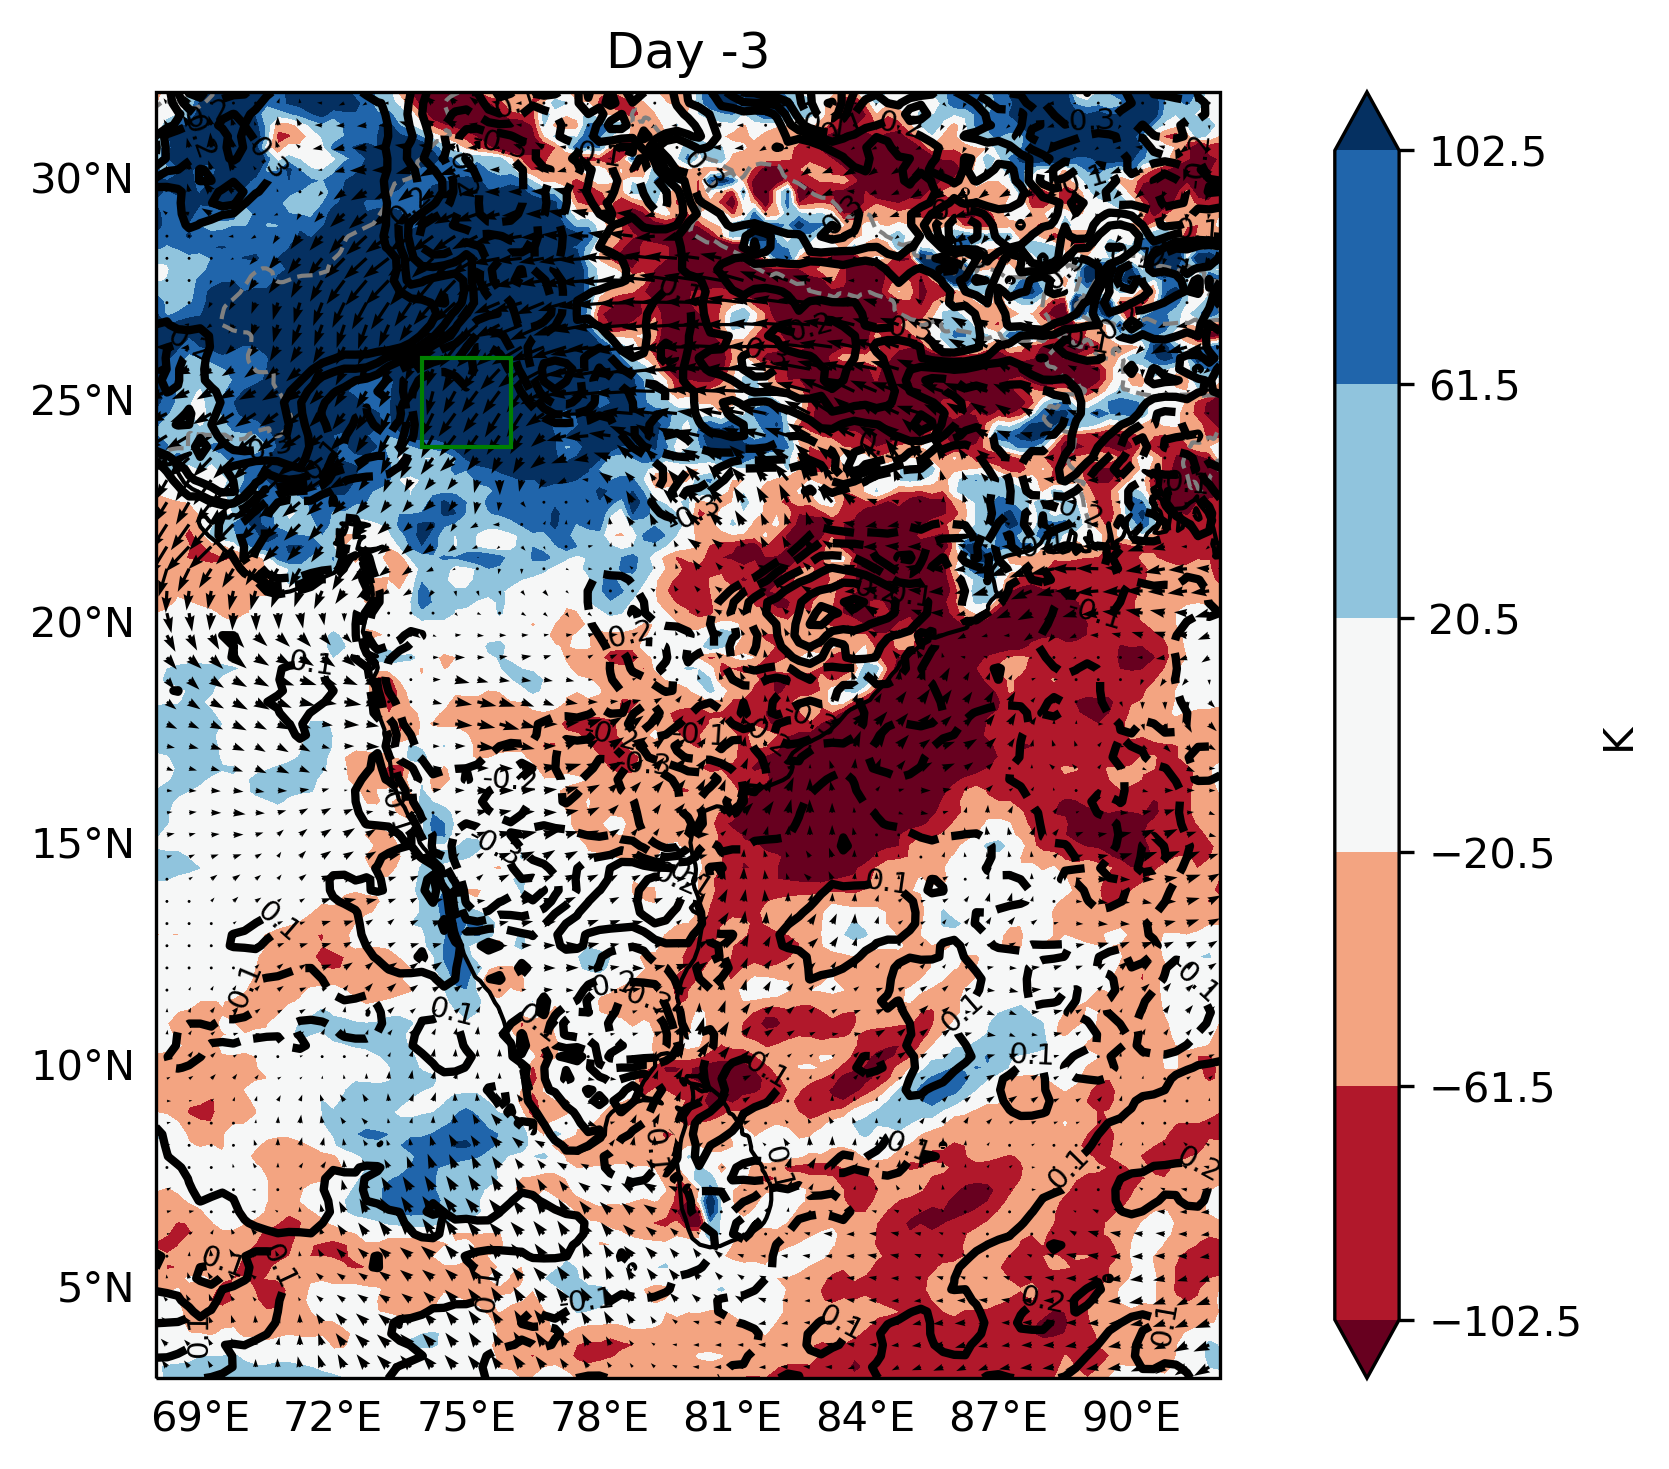

In [40]:
st=2
sarrow = 1
scale = 35
f = plt.figure(figsize=(8,5), dpi=300)

ax = f.add_subplot(111, projection=ccrs.PlateCarree())
lon2d, lat2d = np.meshgrid(dic['lon'],dic['lat'])
xquiv = lon2d[sarrow::st, sarrow::st]
yquiv = lat2d[sarrow::st, sarrow::st]


ws, wd = u_met.u_v_to_ws_wd(dic['u']-dic['u10'], dic['v']-dic['v10']) 

var = dic['cape']
u = dic['u10']
v = dic['v10']
cvar = 't2'
edge = np.max([np.abs(np.percentile(dic[cvar],10)),np.abs(np.percentile(dic[cvar],90))])
levs = np.linspace(edge*-1,edge,6)
contour = {'data' : dic[cvar], 'x': dic['lon'], 'y' : dic['lat'], 'levels' : levs}

edge = np.max([np.abs(np.percentile(var,10)),np.abs(np.percentile(var,90))])
lev = np.linspace(edge*-1,edge,6)

uu = u[sarrow::st, sarrow::st]
vv = v[sarrow::st, sarrow::st]
qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
draw_map(ax, var, dic['lat'], dic['lon'], title='Day -3',  quiver=qin, levels=lev, contour=contour)
f.canvas.draw()
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/NFLICS/plots/small_presi/NFLICS_single_t_slp_uv_1200.jpg')

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


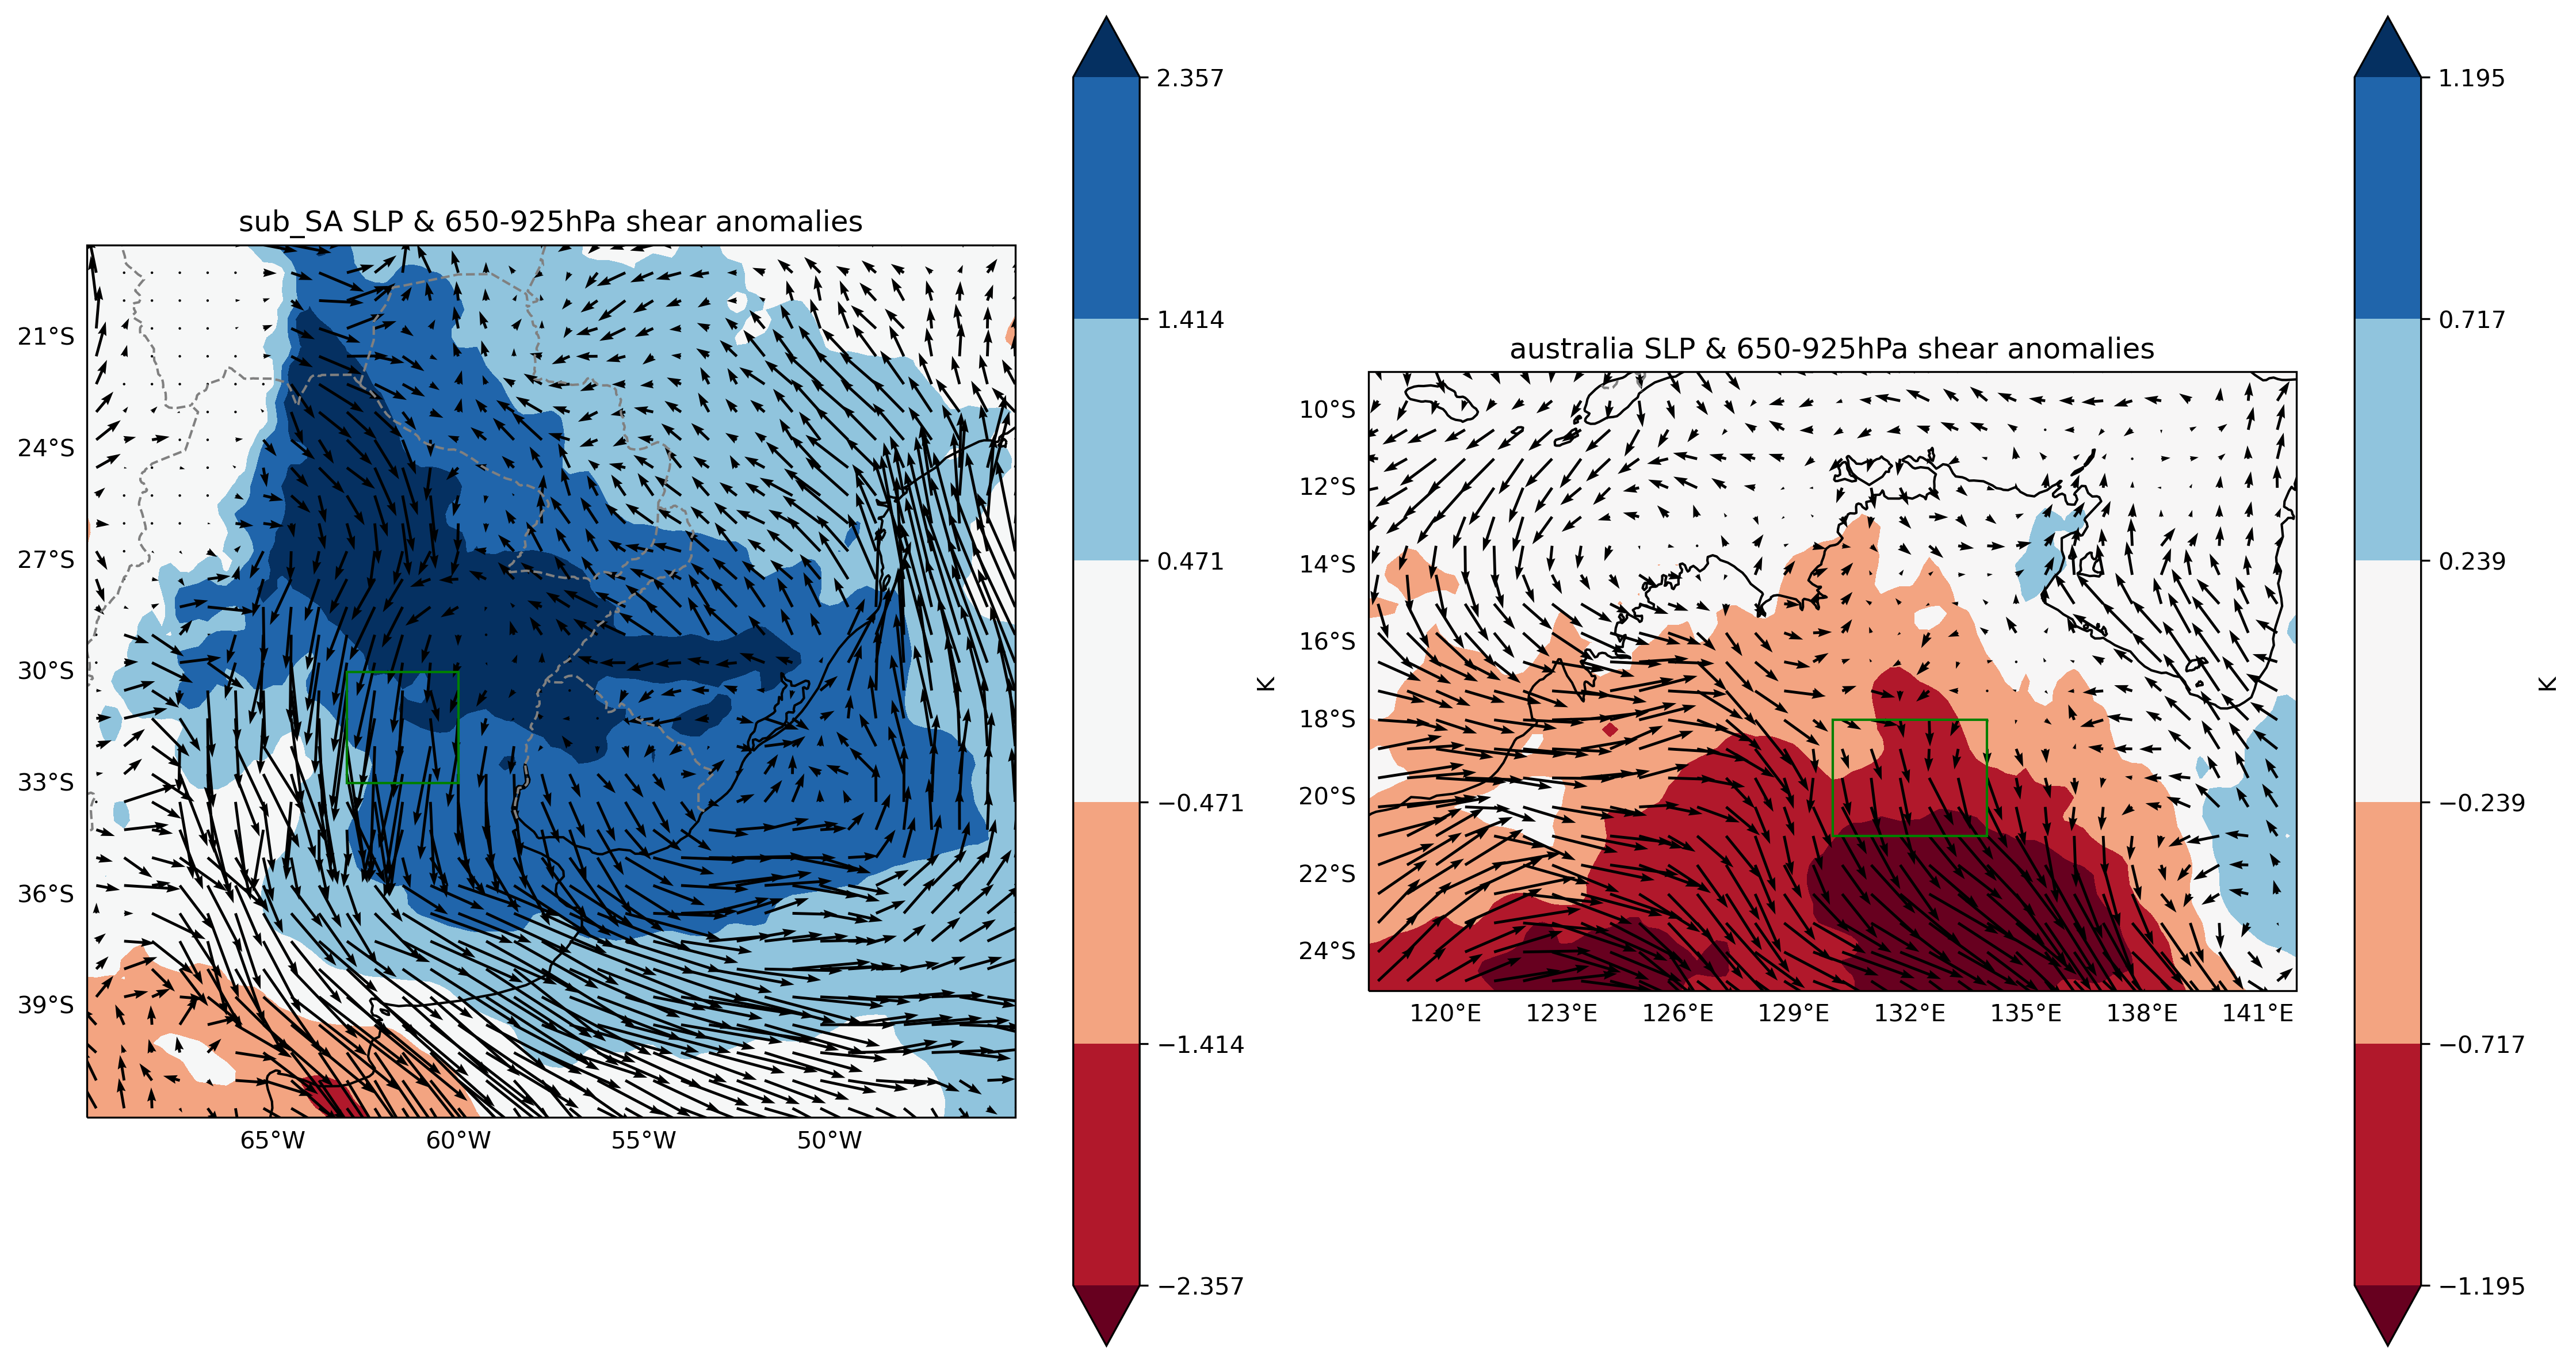

In [89]:
st=3
sarrow = 1
scale = 30
f = plt.figure(figsize=(15,8), dpi=300)
for ids, rreg in enumerate(['sub_SA','australia']):

    dic = pkl.load(open(glob.glob(cnst.DATA+'LMCS/geogComp/'+rreg+'*.p')[0], 'rb'))
    box = MREGIONS[rreg][6]
    
    ax = f.add_subplot(1,2,ids+1, projection=ccrs.PlateCarree())
    lon2d, lat2d = np.meshgrid(dic['lon'],dic['lat'])
    xquiv = lon2d[sarrow::st, sarrow::st]
    yquiv = lat2d[sarrow::st, sarrow::st]


    ws, wd = u_met.u_v_to_ws_wd(dic['u']-dic['u10'], dic['v']-dic['v10']) 
    vstr = 't'
    var = dic[vstr]
    u = dic['ushear']
    v = dic['vshear']
    cvar = 't2'
    edge = np.max([np.abs(np.percentile(dic[cvar],10)),np.abs(np.percentile(dic[cvar],90))])
    levs = np.linspace(edge*-1,edge,6)
    contour = {'data' : dic[cvar], 'x': dic['lon'], 'y' : dic['lat'], 'levels' : levs}

    edge = np.max([np.abs(np.percentile(var,10)),np.abs(np.percentile(var,90))])
    lev = np.linspace(edge*-1,edge,6)

    uu = u[sarrow::st, sarrow::st]
    vv = v[sarrow::st, sarrow::st]
    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
    draw_map(ax, var, dic['lat'], dic['lon'], title=rreg+' SLP & 650-925hPa shear anomalies',  quiver=qin, levels=lev)  #, contour=contour
    #f.canvas.draw()
    plt.tight_layout()
    plt.savefig(cnst.FIGS+'/LMCS/comp_geog/'+vstr+'_'+rreg+'.jpg')

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


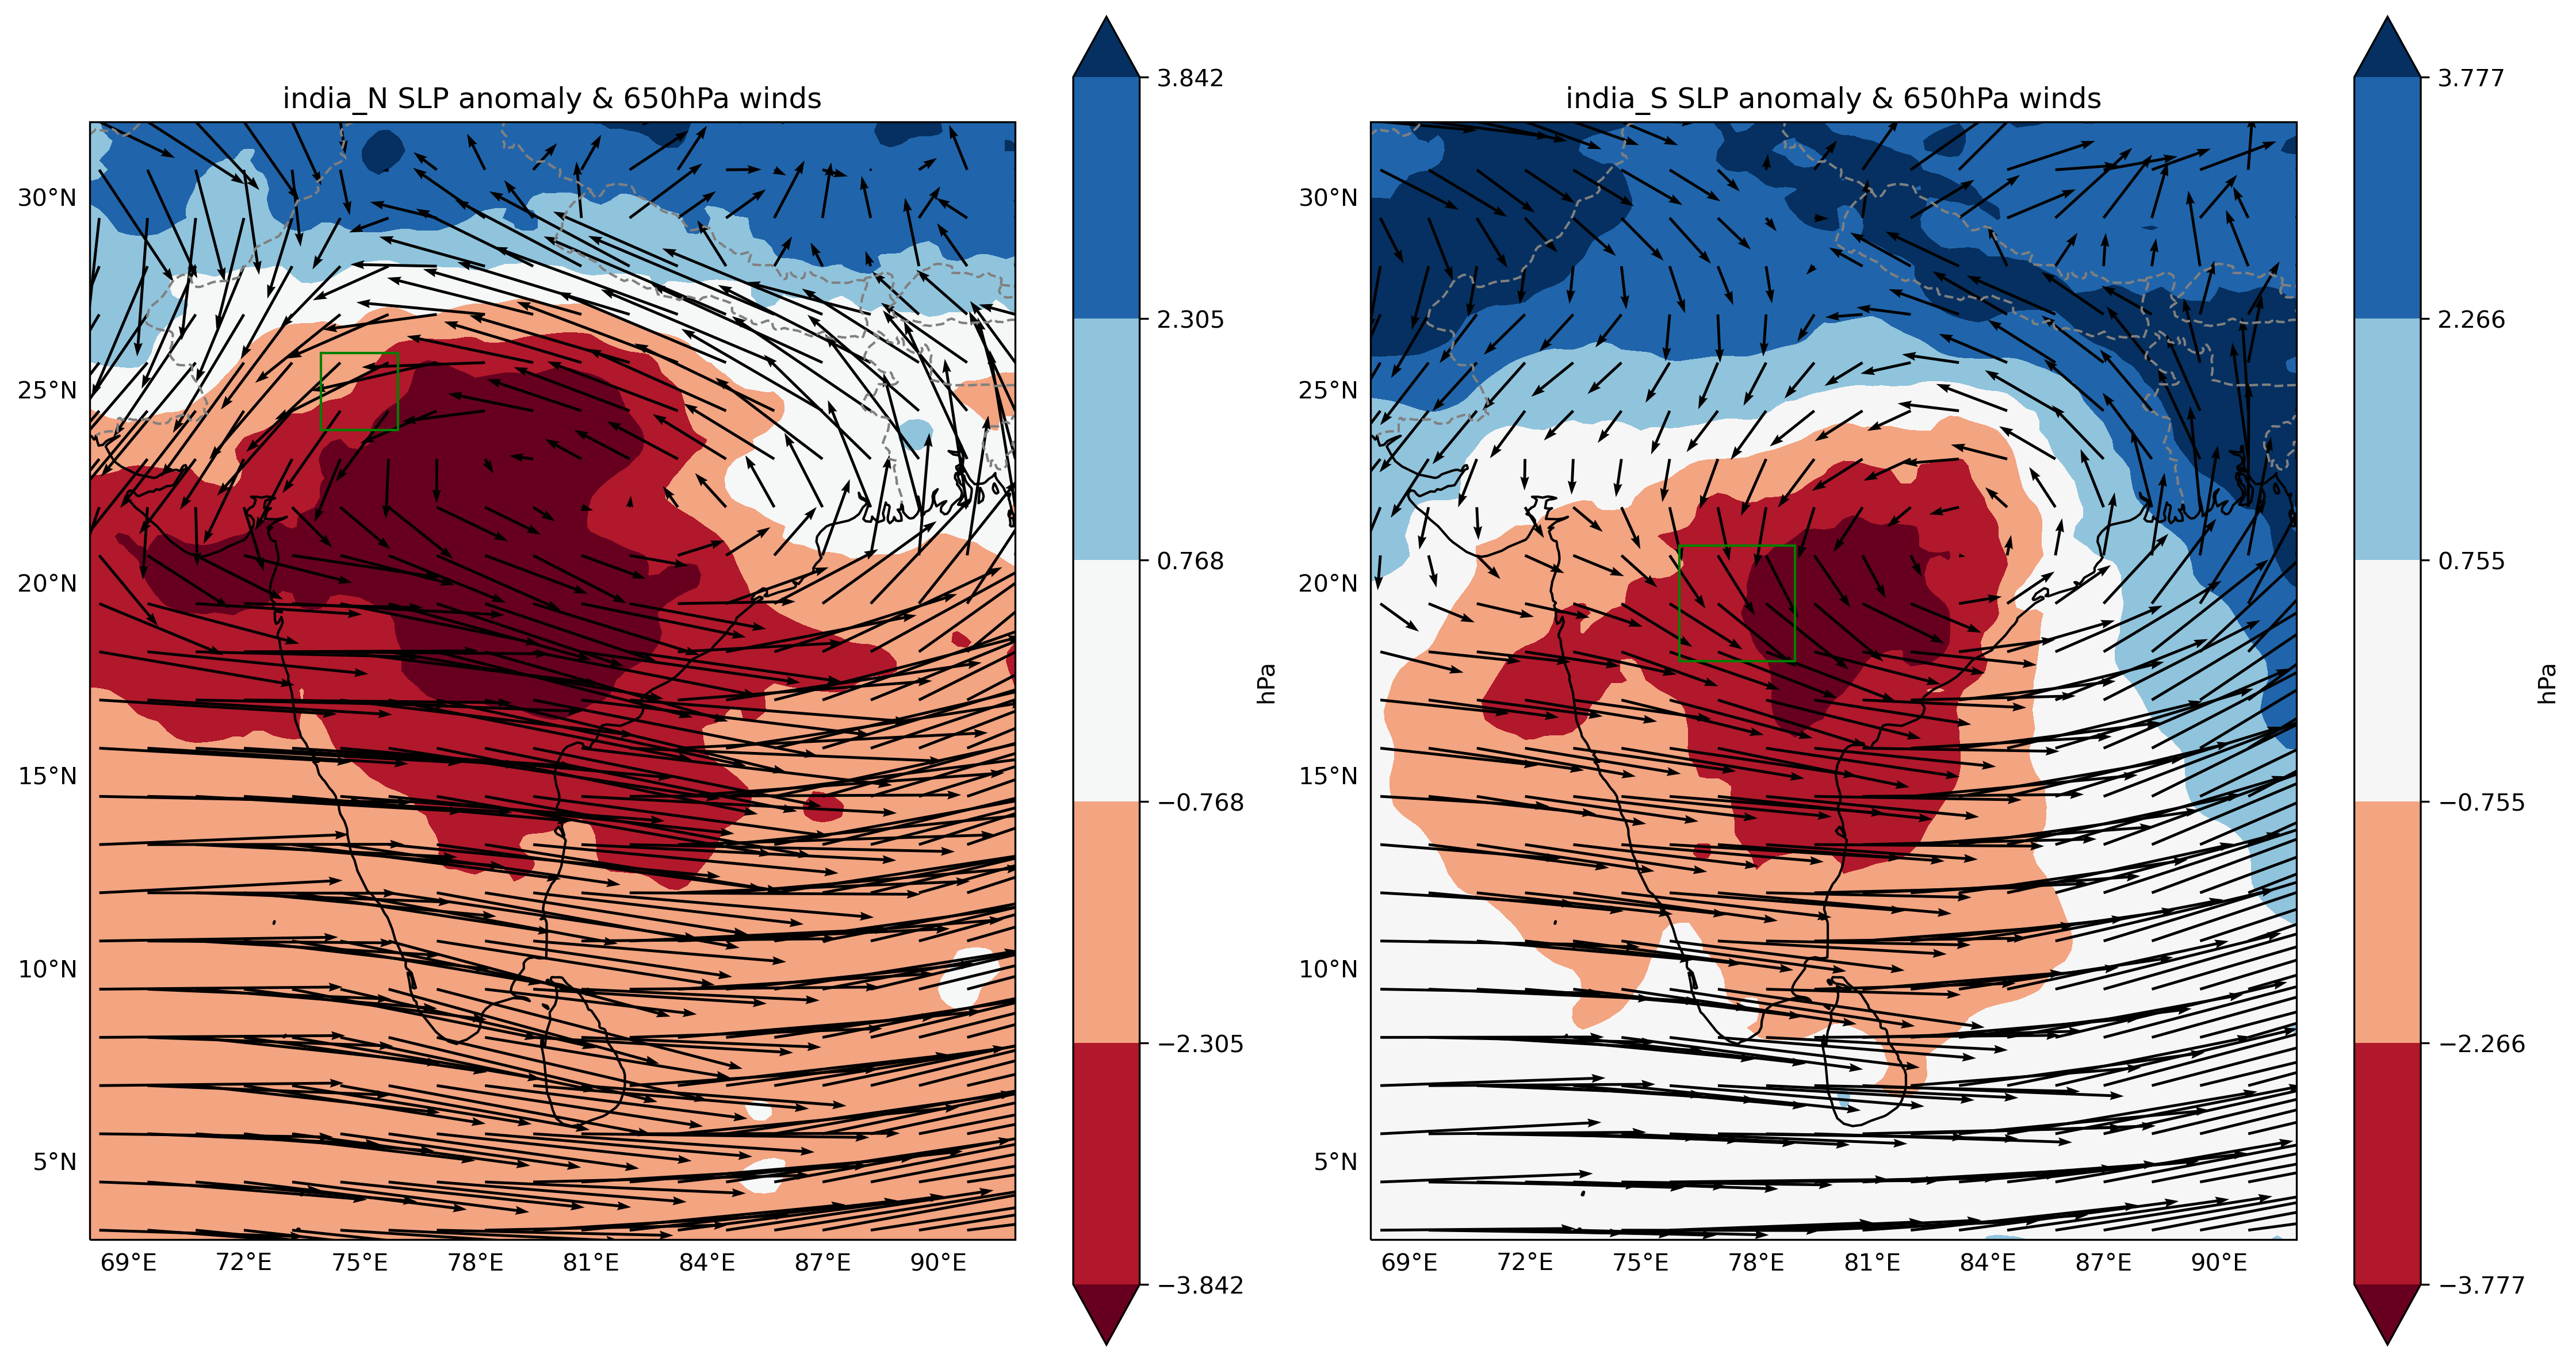

In [97]:
st=5
sarrow = 1
scale = 30
f = plt.figure(figsize=(15,8), dpi=300)
for ids, rreg in enumerate(['india_N','india_S']):

    dic = pkl.load(open(glob.glob(cnst.DATA+'LMCS/geogComp/'+rreg+'*.p')[0], 'rb'))
    box = MREGIONS[rreg][6]
    
    ax = f.add_subplot(1,2,ids+1, projection=ccrs.PlateCarree())
    lon2d, lat2d = np.meshgrid(dic['lon'],dic['lat'])
    xquiv = lon2d[sarrow::st, sarrow::st]
    yquiv = lat2d[sarrow::st, sarrow::st]


    ws, wd = u_met.u_v_to_ws_wd(dic['u']-dic['u10'], dic['v']-dic['v10']) 
    vstr = 'slp'
    var = dic[vstr]/10
    u = dic['u_orig']
    v = dic['v_orig']
    cvar = 't2'
    edge = np.max([np.abs(np.percentile(dic[cvar],10)),np.abs(np.percentile(dic[cvar],90))])
    levs = np.linspace(edge*-1,edge,6)
    contour = {'data' : dic[cvar], 'x': dic['lon'], 'y' : dic['lat'], 'levels' : levs}

    edge = np.max([np.abs(np.percentile(var,10)),np.abs(np.percentile(var,90))])
    lev = np.linspace(edge*-1,edge,6)

    uu = u[sarrow::st, sarrow::st]
    vv = v[sarrow::st, sarrow::st]
    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
    draw_map(ax, var, dic['lat'], dic['lon'], title=rreg+' SLP anomaly & 650hPa winds',  quiver=qin, levels=lev)  #, contour=contour
    #f.canvas.draw()
    plt.tight_layout()
    plt.savefig(cnst.FIGS+'/LMCS/comp_geog/'+vstr+'_'+rreg+'.jpg')

In [164]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap='RdBu', levels=levels, extend='both')
    ax.coastlines()

#     ## quiver list
#     if quiver is not None:
#         qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'], width=0.003, headwidth=3.2)
    
    
        ## additional contour on plot   
    contour=None
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='k', linewidths=2 )
        plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=1,edgecolor='green',facecolor='none', zorder=99)
        
    ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label('g/kg')

In [165]:
box

[-8.5, -8, 12, 12.5]

## 

-1
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_10_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_10_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_08_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_13_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_21_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_20_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_30_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_30_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_30_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_leve

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


0
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_11_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_11_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_09_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_14_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_22_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_21_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_31_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_31_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_31_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_level

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


1
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_12_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_12_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_10_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_15_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_23_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_22_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_01_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_01_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_01_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_level

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_13_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_13_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_11_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_16_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_24_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_23_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_02_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_02_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_02_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


-1
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_10_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_10_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_08_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_13_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_21_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_20_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_30_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_30_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_30_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_leve

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_11_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_11_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_09_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_14_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_22_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_21_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_31_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_31_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_31_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_12_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_12_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_10_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_15_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_23_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_22_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_01_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_01_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_01_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


2
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_13_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_13_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_11_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_16_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_24_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_23_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_02_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_02_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_02_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_level

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


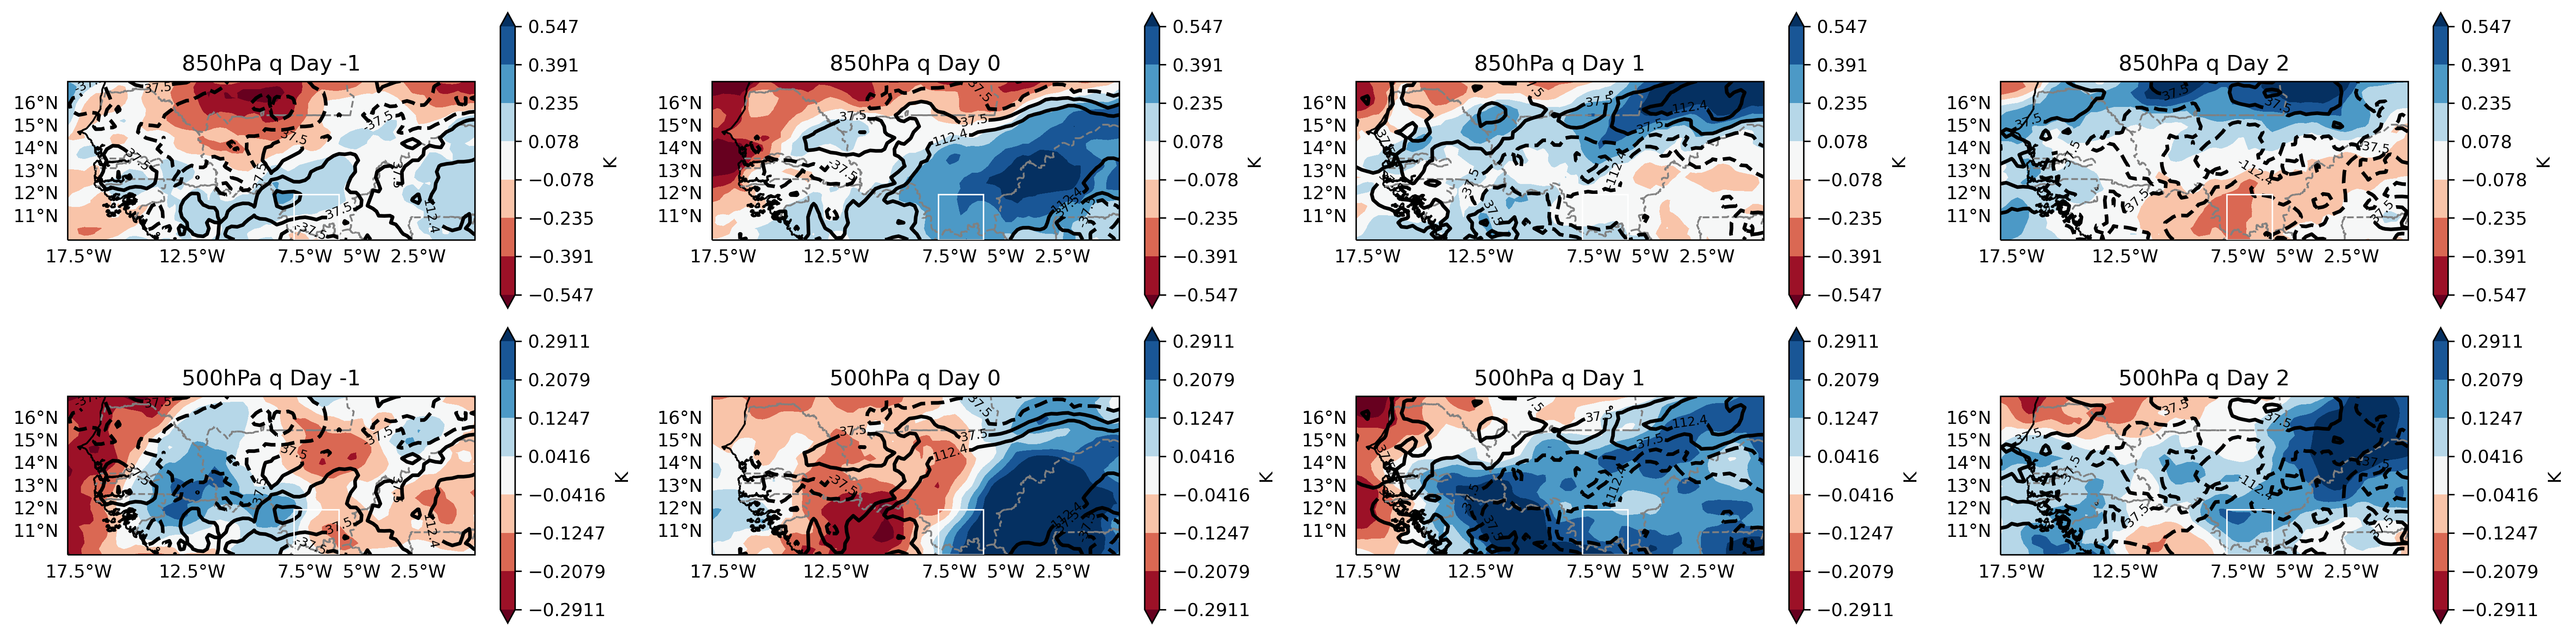

In [59]:
st=2
sarrow = 2
scale = 30
utag = 'u10'
vtag = 'v10'

f = plt.figure(figsize=(20,5), dpi=300)

for ids, num in enumerate([-1, 0,1,2]):

    ax = f.add_subplot(2,4,ids+1, projection=ccrs.PlateCarree())
    print(num)
    dic, lat, lon = run(num)
    dic = calc(dic)
    
    if ids == 0:
        lon2d, lat2d = np.meshgrid(lon,lat)
        xquiv = lon2d[sarrow::st, sarrow::st]
        yquiv = lat2d[sarrow::st, sarrow::st]
    #ipdb.set_trace()
    
    ws, wd = u_met.u_v_to_ws_wd(dic['u_orig']-dic['u10_orig'], dic['v_orig']-dic['v10_orig'])
    vart = 'q'
    var = dic[vart]*1000
    
    if ids == 0:
        edge = np.max([np.abs(np.percentile(var,1)),np.abs(np.percentile(var,99))])
        lev = np.linspace(edge*-1,edge,8) # edge*-1
    #ipdb.set_trace()
    u = dic[utag]
    v = dic[vtag]

    uu = u[sarrow::st, sarrow::st]
    vv = v[sarrow::st, sarrow::st]
    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
    
    
    if vart == 'q':
        vtags = '850hPa q'
    if vart == 'qup':
        vtags = '500hPa q'
    
    cvar = 'cape'
    invar = dic[cvar]
    if ids == 0:
        edge = np.max([np.abs(np.percentile(invar,5)),np.abs(np.percentile(invar,95))])
        levs = np.linspace(edge*-1,edge,4) # edge*-1
    contour = {'data' : invar, 'x' : lon, 'y' : lat, 'levels' : levs}
    
    draw_map(ax, var, lat, lon, title=vtags+' Day '+str(num),  quiver=qin, levels=lev, contour=contour)  #levels=lev,
    
    
for ids, num in enumerate([-1, 0,1,2]):
    

    ax = f.add_subplot(2,4,ids+1+4, projection=ccrs.PlateCarree())
    print(num)
    dic, lat, lon = run(num)
    dic = calc(dic)
    
    if ids == 0:
        lon2d, lat2d = np.meshgrid(lon,lat)
        xquiv = lon2d[sarrow::st, sarrow::st]
        yquiv = lat2d[sarrow::st, sarrow::st]
    #ipdb.set_trace()
    
    ws, wd = u_met.u_v_to_ws_wd(dic['u_orig']-dic['u10_orig'], dic['v_orig']-dic['v10_orig'])
    vart = 'qup'
    var = dic[vart]*1000
    
    if ids == 0:
        edge = np.max([np.abs(np.percentile(var,1)),np.abs(np.percentile(var,99))])
        lev = np.linspace(edge*-1,edge,8) # edge*-1
    #ipdb.set_trace()
    u = dic[utag]
    v = dic[vtag]

    uu = u[sarrow::st, sarrow::st]
    vv = v[sarrow::st, sarrow::st]
    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
    
    
    cvar = 'cape'
    invar = dic[cvar]
    if ids == 0:
        edge = np.max([np.abs(np.percentile(invar,5)),np.abs(np.percentile(invar,95))])
        levs = np.linspace(edge*-1,edge,4) # edge*-1
    contour = {'data' : invar, 'x' : lon, 'y' : lat, 'levels' : levs}
    
    if vart == 'q':
        vtags = '850hPa q'
    if vart == 'qup':
        vtags = '500hPa q'
    
    draw_map(ax, var, lat, lon, title=vtags+' Day '+str(num),  quiver=qin, levels=lev, contour=contour)  #levels=lev,

f.canvas.draw()
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/NFLICS/plots/cb_same/NFLICS_ERA5anomaly_dakarstorms_anom_qtest.jpg')

In [ ]:
#np.sum((tab.lon>-5) & (tab.lon<-4) & (tab.lat>12) & (tab.lat<15))

In [ ]:
#(tab.lon>-5.5) & (tab.lon<-5) & (tab.lat>12) & (tab.lat<12.5)